In [1]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import os
import re
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [2]:
news = []
print("News Directory:")
for dirname, _, filenames in os.walk("./data/"):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        df = pd.read_csv(os.path.join(dirname, filename), index_col = None, header = 0)
        row, cols = df.shape
        news.append(df)
        
data_set = pd.concat(news, axis=0, ignore_index=True)
del news

print()
print("Article Sample:")
print(data_set.news_article.sample(5))

print()
print("Data Columns:")
print(*data_set.columns, sep=", ")

News Directory:
./data/inshort_news_data-1.csv
./data/inshort_news_data-2.csv
./data/inshort_news_data-3.csv
./data/inshort_news_data-4.csv
./data/inshort_news_data-5.csv
./data/inshort_news_data-6.csv
./data/inshort_news_data-7.csv

Article Sample:
691      Talking about working with Sanjay Dutt in the ...
4170     Saudi Prince Turki Al-Faisal, during a securit...
7526     Actor Anil Nedumangad, known for his roles in ...
11858    Samajwadi Party (SP) chief Akhilesh Yadav on M...
6250     Former Australia captain Ricky Ponting has sai...
Name: news_article, dtype: object

Data Columns:
Unnamed: 0, news_headline, news_article, news_category


In [5]:
class_labels  = data_set["news_category"].values.tolist()
class_labels_set = set(class_labels)

freq_list = []

for c in class_labels_set:
    freq_list.append(class_labels.count(c))

print('Freq',freq_list)
print('category',class_labels_set)

Freq [1596, 1900, 2067, 1791, 2036, 1293, 1437]
category {'politics', 'sports', 'world', 'technology', 'entertainment', 'automobile', 'science'}


In [4]:
data_set.head()

,Unnamed: 0,news_headline,news_article,news_category
0,0,50-year-old problem of biology solved by Artif...,DeepMind's AI system 'AlphaFold' has been reco...,technology
1,1,Microsoft Teams to stop working on Internet Ex...,Microsoft Teams will stop working on Internet ...,technology
2,2,Hope US won't erect barriers to cooperation: C...,"China, in response to reports of US adding Chi...",technology
3,3,Global smartphone sales in Q3 falls 5.7% to 36...,The global smartphone sales in the third quart...,technology
4,4,EU hoping Biden will clarify US position on di...,The European Union (EU) is hoping that US Pres...,technology


In [5]:
data_set.shape

(12120, 4)

In [6]:
data_set.describe(include = "all")

,Unnamed: 0,news_headline,news_article,news_category
count,12120.000000,12120,12120,12120
unique,NaN,5113,5183,7
top,NaN,Own a car without buying it : Revv Subscriptions,You can now drive a new car every month as Rev...,world
freq,NaN,41,41,2067
mean,1378.089191,NaN,NaN,NaN
std,1261.832631,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN
25%,446.000000,NaN,NaN,NaN
50%,951.000000,NaN,NaN,NaN
75%,1786.250000,NaN,NaN,NaN


In [7]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     12120 non-null  int64 
 1   news_headline  12120 non-null  object
 2   news_article   12120 non-null  object
 3   news_category  12120 non-null  object
dtypes: int64(1), object(3)
memory usage: 378.9+ KB


In [8]:
data_set.isna().sum()

Unnamed: 0       0
news_headline    0
news_article     0
news_category    0
dtype: int64

In [9]:
data_set = data_set.drop("Unnamed: 0", axis = 1)
data_set

,news_headline,news_article,news_category
0,50-year-old problem of biology solved by Artif...,DeepMind's AI system 'AlphaFold' has been reco...,technology
1,Microsoft Teams to stop working on Internet Ex...,Microsoft Teams will stop working on Internet ...,technology
2,Hope US won't erect barriers to cooperation: C...,"China, in response to reports of US adding Chi...",technology
3,Global smartphone sales in Q3 falls 5.7% to 36...,The global smartphone sales in the third quart...,technology
4,EU hoping Biden will clarify US position on di...,The European Union (EU) is hoping that US Pres...,technology
...,...,...,...
12115,2 IAF doctors to soon leave for Russia to trai...,Two Indian Air Force doctors who have speciali...,science
12116,NASA finds FM signal coming from Jupiter's moo...,NASA's Juno space probe has discovered an FM s...,science
12117,New state of matter 'liquid glass' discovered:...,University of Konstanz's researchers have unco...,science
12118,Astrophysicist Shashikumar Madhusudan Chitre p...,Renowned astrophysicist Professor Shashikumar ...,science


In [10]:
labelEncoder_X = LabelEncoder()
data_set["news_category"] = labelEncoder_X.fit_transform(data_set["news_category"])
data_set.head()

,news_headline,news_article,news_category
0,50-year-old problem of biology solved by Artif...,DeepMind's AI system 'AlphaFold' has been reco...,5
1,Microsoft Teams to stop working on Internet Ex...,Microsoft Teams will stop working on Internet ...,5
2,Hope US won't erect barriers to cooperation: C...,"China, in response to reports of US adding Chi...",5
3,Global smartphone sales in Q3 falls 5.7% to 36...,The global smartphone sales in the third quart...,5
4,EU hoping Biden will clarify US position on di...,The European Union (EU) is hoping that US Pres...,5


In [12]:
corpus = []
words = []
ps = PorterStemmer()
for i in range(0, len(data_set)):
    review = data_set["news_article"][i]
    review = re.sub("[^a-zA-Z]", " ", review)
    review = review.lower()
    review = review.split()
    review = [word for word in review if not word in set(stopwords.words("english"))]
    for j in review:
        words.append(j)
    review = [ps.stem(word1) for word1 in review]
    review = " ".join(review)
    corpus.append(review)

In [13]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
y = data_set.iloc[:, -1].values

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

Accuracy of Support Vector Classifier is: 93.56435643564357%

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       251
           1       0.95      0.95      0.95       423
           2       0.99      0.96      0.97       322
           3       0.96      0.99      0.97       274
           4       0.98      0.97      0.98       411
           5       0.86      0.82      0.84       345
           6       0.89      0.89      0.89       398

    accuracy                           0.94      2424
   macro avg       0.94      0.94      0.94      2424
weighted avg       0.94      0.94      0.94      2424



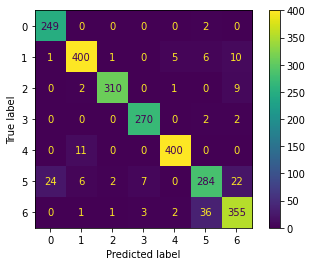

In [29]:
svc = SVC(kernel = "rbf")
svc.fit(X_train, y_train)

y_pred_svc = svc.predict(X_test)

print(f"Accuracy of Support Vector Classifier is: {accuracy_score(y_test, y_pred_svc) * 100}%")
print()
print(classification_report(y_test, y_pred_svc))

cm = confusion_matrix(y_test, y_pred_svc)
disp = ConfusionMatrixDisplay(cm)
disp.plot()